In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
%matplotlib inline

from pykdf.kdf import save_kdf, load_kdf
from fakespikes.rates import bursts
from fakespikes.neurons import Spikes
from fakespikes.util import create_psd
import fakespikes.util as sp
from copy import deepcopy
import numpy as np

import seaborn as sns
sns.set_style('ticks')

/home/ejp/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# %run ../exp/fig2.py ../data/fig2

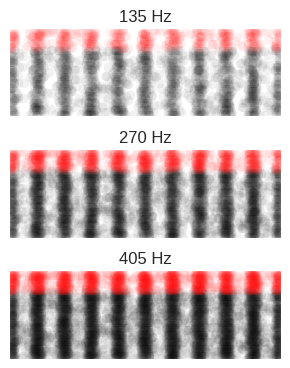

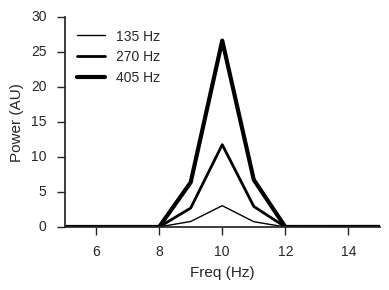

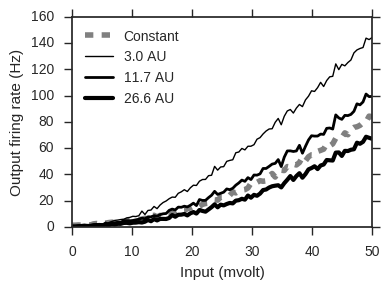

In [3]:
# No osc
res_f1a = load_kdf('../data/fig1/a.hdf5')
fi1 = res_f1a['fi1']


# Osc
res_a = load_kdf('../data/fig2/a.hdf5')
fis = res_a['fis']
amps = res_a['amps']
Is = res_a['Is'] * 1000

plt.figure(figsize=(3, 5))
rates = []
arates = []
for k, a in enumerate(amps):
    nrns = Spikes(50, 1, dt=1e-3, seed=42)
    times = nrns.times
    
    r = 135 * a
    rate = bursts(times, r, res_a['f'], None, min_a=12 * a)
    
    sub = plt.subplot(4, 1, k + 1)
    spks = nrns.poisson(rate)
    ns, ts = sp.to_spiketimes(times, spks)
    
    m = ns < int(ns.max() * 0.8) 
    plt.plot(ts[m], ns[m], 'ok', alpha=0.05)

    m = ns >= int(ns.max() * 0.8) 
    plt.plot(ts[m], ns[m], 'or', alpha=0.05)
        
    sub.set_frame_on(False)
    sub.get_yaxis().set_visible(False)
    sub.get_xaxis().set_visible(False)
    
    plt.title("{} Hz".format(r.max()))
    
    rates.append(spks.sum(1))
    arates.append(r)

plt.xlabel("Time (s)")
plt.tight_layout()

# plot PSDs
plt.figure(figsize=(4, 3))

power = []
for k, (r, ar) in enumerate(zip(rates, arates)):
    fs, psd = create_psd(r, 1000)
    plt.plot(fs, psd, linewidth=k+1, color='k', label='{} Hz'.format(ar))
    plt.xlim(5, 15)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("Power (AU)")
    plt.legend(loc='upper left')

    power.append(psd[fs > 5].max())
plt.tight_layout()
sns.despine()

# --
plt.figure(figsize=(4, 3))

plt.plot(Is, fi1, label='Constant', color='grey', linewidth=4, linestyle="--")

for k, (a, fi) in enumerate(zip(power, fis)):
    plt.plot(Is, fi, label=str(np.round(a, 1)) + ' AU', linewidth=k + 1, color='k')
plt.xlim(0, 26)
plt.xlabel("Input (mvolt)")
plt.ylabel("Output firing rate (Hz)")
plt.xlim(0, 50)
plt.ylim(0, 160)
plt.legend(loc='upper left')
plt.tight_layout()
# sns.despine()

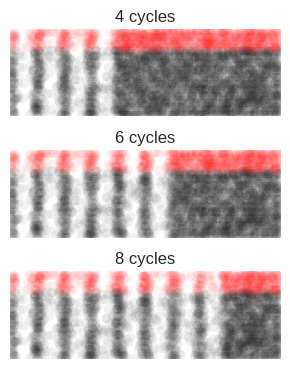

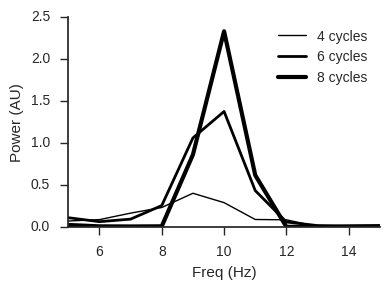

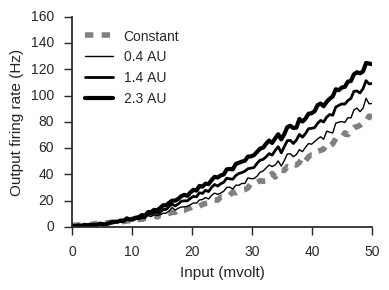

In [4]:
res_b = load_kdf('../data/fig2/b.hdf5')
fis = res_b['fis']
n_bursts = res_b['n_bursts'][1:]

# --
plt.figure(figsize=(3, 5))
ax = plt.axes(frameon=False)

arates = []
rates = []
for k, a in enumerate(n_bursts):
    nrns = Spikes(50, 1, dt=1e-3, seed=42)
    times = nrns.times
    
    r = 125 
    rate = bursts(times, r, res_a['f'], a, min_a=12)
    
    sub = plt.subplot(4, 1, k + 1)
    spks = nrns.poisson(rate)
    ns, ts = sp.to_spiketimes(times, spks)
    
    m = ns < int(ns.max() * 0.8) 
    plt.plot(ts[m], ns[m], 'ok', alpha=0.05)

    m = ns >= int(ns.max() * 0.8) 
    plt.plot(ts[m], ns[m], 'or', alpha=0.05)
        
    sub.set_frame_on(False)
    sub.get_yaxis().set_visible(False)
    sub.get_xaxis().set_visible(False)
    
    plt.title("{} cycles".format(a))
    
    rates.append(spks.sum(1))
    arates.append(a)
    
plt.tight_layout()

# plot PSDs
plt.figure(figsize=(4, 3))
power = []
for k, (r, ar) in enumerate(zip(rates, arates)):
    fs, psd = create_psd(r, 1000)
    plt.plot(fs, psd, linewidth=k+1, color='k', label='{} cycles'.format(ar))
    plt.xlim(5, 15)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("Power (AU)")
    plt.legend(loc='upper right')

    power.append(psd[fs > 5].max())
    
plt.tight_layout()
sns.despine()
    
# --
# --
plt.figure(figsize=(4, 3))
plt.plot(Is, fi1, label='Constant', color='grey', linewidth=4, linestyle="--")

for k, (a, fi) in enumerate(zip(power, fis)):
    plt.plot(Is, fi, label=str(np.round(a, 1)) + ' AU', linewidth=k + 1, color='k')
plt.xlim(0, 26)
plt.xlabel("Input (mvolt)")
plt.ylabel("Output firing rate (Hz)")
plt.xlim(0, 50)
plt.ylim(0,160)
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine()

In [5]:
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    
    return y

def find_bursts(x, start=4, end=2):
    x = deepcopy(x)
#     x -= np.median(x)
#     x /= np.std(x)
    
    bursts = []
    burst = []
    b = False
    for i, xt in enumerate(x):
        # start of a burst
        if xt >= start:
            b = True
        
        if b:
            # Still bursting?
            if xt >= end:
                burst.append(i)
            else:
                # we're below the thresh. store
                bursts.append(deepcopy(burst))
            
                # and then reset
                burst = []
                b = False
        
    return bursts

## Example data from single subject.

In [6]:
t = 120 # seconds long
alpha = loadmat('alpha_data.mat')
times = np.linspace(0, 120, 120*500)

rest = alpha['oz_dat_rest'][0,:]
rest -= np.median(rest)

task = alpha['oz_dat_task'][0,:]
task -= np.median(task)

# smooth a little
rest = butter_bandpass_filter(rest, .1, 30, 500, order=2)
rest_pow = np.abs(hilbert(butter_bandpass_filter(rest, 8, 12, 500, order=2)))

task = butter_bandpass_filter(task, .1, 30, 500, order=2)
task_pow = np.abs(hilbert(butter_bandpass_filter(task, 8, 12, 500, order=2)))

# Find burst indices
rest_b = find_bursts(rest_pow)
task_b = find_bursts(task_pow)

# Burst stats
print(len(rest_b))
print(len(task_b))

# Burst lengths
srate = 1000
avg_cycle_n = 1
rest_b_times = [len(b) / float(srate * avg_cycle_n) for b in rest_b]
task_b_times = [len(b) / float(srate * avg_cycle_n) for b in task_b]

# Burst peak power
rest_bpow = [rest_pow[b].mean() for b in rest_b]
task_bpow = [task_pow[b].mean() for b in task_b]

23
84


(0.0, 4.0, -40.0, 40.0)

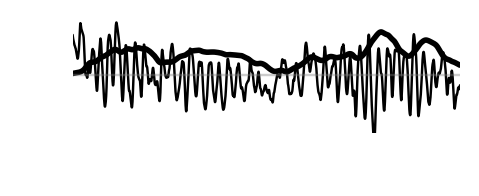

In [7]:
# plt.figure(figsize=(5, 1.5))
plt.figure(figsize=(5, 1.5))
plt.plot(times[:2000], rest[4000:6000], color='k')
plt.plot(times[:2000], rest_pow[4000:6000], color='k', linewidth=4)
plt.axhline(0, color='grey', alpha=0.4)
plt.ylim(-40, 40)
plt.xlabel("Time (s)")
plt.ylabel("EEG (uvolt)")
plt.axis('off')

(0.0, 4.0, -40.0, 40.0)

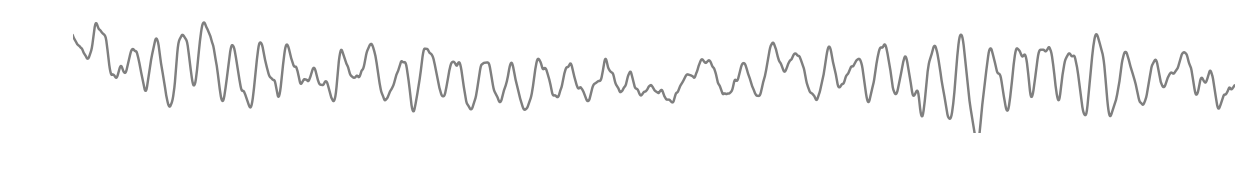

In [8]:
# plt.figure(figsize=(5, 1.5))
plt.figure(figsize=(15, 1.5))
plt.plot(times[:2000], rest[4000:6000], color='k', alpha=0.5)
# plt.plot(times[:2000], rest_pow[4000:6000], color='k', linewidth=4)
# plt.axhline(0, color='grey', alpha=0.4)
plt.ylim(-40, 40)
plt.xlabel("Time (s)")
plt.ylabel("EEG (uvolt)")
plt.axis('off')

(0.0, 4.0, -40.0, 40.0)

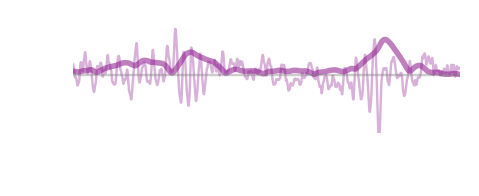

In [9]:
plt.figure(figsize=(5, 1.5))
plt.plot(times[:2000], task[4000:6000], color='purple', alpha=0.3)
plt.plot(times[:2000], task_pow[4000:6000], color='purple', linewidth=4, alpha=0.5)
plt.axhline(0, color='grey', alpha=0.4)
plt.ylim(-40, 40)
plt.xlabel("Time (s)")
plt.ylabel("EEG (uvolt)")
plt.axis('off')

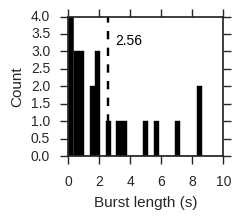

In [10]:
M = np.mean(rest_b_times)

plt.figure(figsize=(2, 1.8))
plt.hist(rest_b_times, bins=np.linspace(0, 10, 30), color='k');
plt.xlabel("Burst length (s)")
plt.ylabel("Count")

plt.axvline(x=M, color='k', linestyle='--')
plt.annotate(str(np.round(M, 2)), xy=(0.30, 0.80), xycoords='axes fraction', color='k')

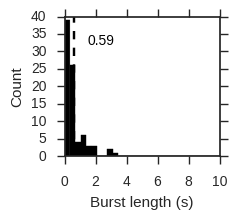

In [11]:
M = np.mean(task_b_times)
plt.figure(figsize=(2, 1.8))
plt.hist(task_b_times, bins=np.linspace(0, 10, 30), color='k');
plt.xlabel("Burst length (s)")
plt.ylabel("Count")
# plt.ylim(0, 70)
plt.axvline(x=M, color='k', linestyle='--')
plt.annotate(str(np.round(M, 2)), xy=(0.15, 0.80), xycoords='axes fraction', color='k')

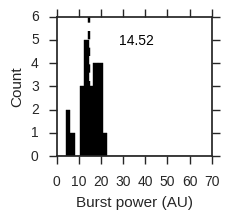

In [12]:
M = np.mean(rest_bpow)
plt.figure(figsize=(2, 1.8))
plt.hist(rest_bpow, bins=np.linspace(0, 60, 30), color='k');
plt.xlabel("Burst power (AU)")
plt.ylabel("Count")
plt.ylim(0, 6)
plt.axvline(x=M, color='k', linestyle='--')
plt.annotate(str(np.round(M, 2)), xy=(0.4, 0.80), xycoords='axes fraction', color='k')

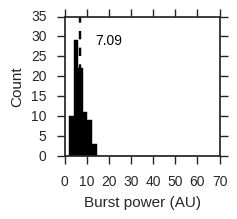

In [13]:
M = np.mean(task_bpow)
plt.figure(figsize=(2, 1.8))
plt.hist(task_bpow, bins=np.linspace(0, 60, 30), color='k');
plt.xlabel("Burst power (AU)")
plt.ylabel("Count")
plt.ylim(0, 35)
plt.axvline(x=M, color='k', linestyle='--')
plt.annotate(str(np.round(M, 2)), xy=(0.2, 0.80), xycoords='axes fraction', color='k')

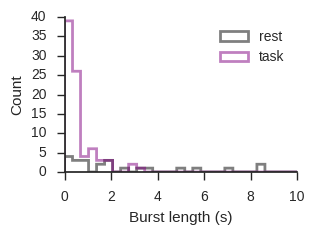

In [14]:
plt.figure(figsize=(3, 2))
plt.hist(rest_b_times, bins=np.linspace(0, 10, 30), 
         color='K', alpha=0.5, histtype='step', label='rest', linewidth=2);
plt.hist(task_b_times, bins=np.linspace(0, 10, 30), 
         color='purple', alpha=0.5, histtype='step', label='task', linewidth=2);
plt.xlabel("Burst length (s)")
plt.legend()
plt.ylabel("Count")
sns.despine()
# plt.ylim(0, 35)

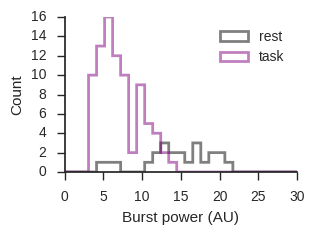

In [15]:
plt.figure(figsize=(3, 2))
plt.hist(rest_bpow, bins=np.linspace(0, 30, 30), 
         color='K', alpha=0.5, histtype='step', label='rest', linewidth=2);
plt.hist(task_bpow, bins=np.linspace(0, 30, 30), 
         color='purple', alpha=0.5, histtype='step', label='task', linewidth=2);
plt.xlabel("Burst power (AU)")
plt.legend()
plt.ylabel("Count")
sns.despine()
# plt.ylim(0, 35)

## Data from many subjects/tasks

In [16]:
t = 120 # seconds long

start = 2 # * SD; burst criterion
stop = 1

rest_l = []
rest_p = []
task_l = []
task_p = []

# A list of all S files
S = range(2000, 2014) + range(1000, 1015)

for s in S:    
    alpha = loadmat('EEG_alpha_phase/{}.mat'.format(s))
    times = np.linspace(0, 120, 120 * 500)

    rest = alpha['oz_rest_data'][0,:]
    rest -= np.median(rest)

    task = alpha['oz_trial_data'][0,:]
    task -= np.median(task)

    # smooth a little
    rest = butter_bandpass_filter(rest, .1, 30, 500, order=2)
    rest_pow = np.abs(hilbert(butter_bandpass_filter(rest, 8, 12, 500, order=2)))

    task = butter_bandpass_filter(task, .1, 30, 500, order=2)
    task_pow = np.abs(hilbert(butter_bandpass_filter(task, 8, 12, 500, order=2)))

    # Find burst indices
    rest_b = find_bursts(rest_pow, rest_pow.std()*start, rest_pow.std()*stop)
    task_b = find_bursts(task_pow, task_pow.std()*start, task_pow.std()*stop)

    # Burst lengths
    srate = 1000
    avg_cycle_n = 1
    rest_b_times = [len(b) / float(srate * avg_cycle_n) for b in rest_b]
    task_b_times = [len(b) / float(srate * avg_cycle_n) for b in task_b]
    
    rest_l.extend(rest_b_times)
    task_l.extend(task_b_times)

    # Burst mean power
    rest_bpow = [rest_pow[b].mean() for b in rest_b]
    task_bpow = [task_pow[b].mean() for b in task_b]

#     # Burst peak power
#     # (same results as mean)
#     rest_bpow = [rest_pow[b].max() for b in rest_b]
#     task_bpow = [task_pow[b].max() for b in task_b]
    
    rest_p.extend(rest_bpow)
    task_p.extend(task_bpow)
    
    
# Pick example data
alpha = loadmat('EEG_alpha_phase/1007.mat')
times = np.linspace(0, 120, 120 * 500)

rest = alpha['oz_rest_data'][0,:]
rest -= np.median(rest)

task = alpha['oz_trial_data'][0,:]
task -= np.median(task)

# smooth a little
rest = butter_bandpass_filter(rest, .1, 30, 500, order=2)
rest_pow = np.abs(hilbert(butter_bandpass_filter(rest, 8, 12, 500, order=2)))

task = butter_bandpass_filter(task, .1, 30, 500, order=2)
task_pow = np.abs(hilbert(butter_bandpass_filter(task, 8, 12, 500, order=2)))

(40.0, 45.0, -100.0, 100.0)

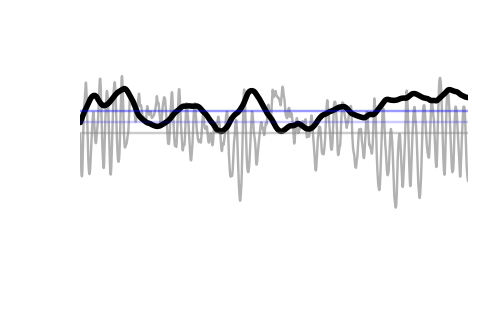

In [17]:
plt.figure(figsize=(5, 3))
plt.plot(times, rest, color='k', alpha=0.3)
plt.plot(times, rest_pow, color='k', linewidth=4)
plt.axhline(rest_pow.std()*start, color='blue', alpha=0.4)
plt.axhline(rest_pow.std()*stop, color='blue', alpha=0.2)
plt.axhline(0, color='grey', alpha=0.4)
plt.ylim(-100, 100)
plt.xlabel("Time (s)")
plt.ylabel("EEG (uvolt)")
plt.xlim(40, 45)
plt.axis('off')

(50, 55)

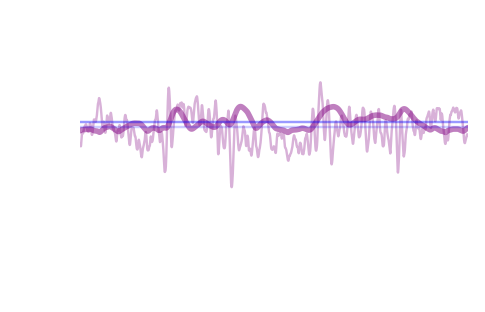

In [18]:
plt.figure(figsize=(5, 3))
plt.plot(times, task, color='purple', alpha=0.3)
plt.plot(times, task_pow, color='purple', linewidth=4, alpha=0.5)
plt.axhline(task_pow.std()*start, color='blue', alpha=0.4)
plt.axhline(task_pow.std()*stop, color='blue', alpha=0.2)
# plt.axhline(0, color='grey', alpha=0.4)
plt.xlabel("Time (s)")
plt.ylim(-100, 100)
plt.ylabel("EEG (uvolt)")
plt.axis('off')
plt.xlim(50, 55)

2571 3535 1.37495138079
0.392202255932 0.20441980198 0.521210163605
0.238 0.147 0.617647058824


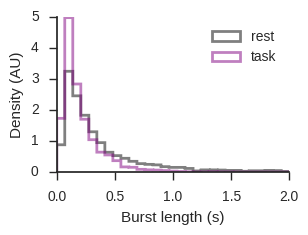

In [19]:
plt.figure(figsize=(3, 2))
plt.hist(rest_l, bins=np.linspace(0, 2, 30), 
         color='K', alpha=0.5, histtype='step', label='rest', linewidth=2, normed=1);
plt.hist(task_l, bins=np.linspace(0, 2, 30), 
         color='purple', alpha=0.5, histtype='step', label='task', linewidth=2, normed=1);
plt.xlabel("Burst length (s)")
plt.legend()
plt.ylabel("Density (AU)")
sns.despine()

print(len(rest_l), len(task_l), len(task_l)/len(rest_l))
print(np.mean(rest_l), np.mean(task_l), np.mean(task_l)/np.mean(rest_l))
print(np.median(rest_l), np.median(task_l), np.median(task_l)/np.median(rest_l))

14.7061291674 7.47900447815 0.508563769092
14.2317571569 6.61957543704 0.465127065061


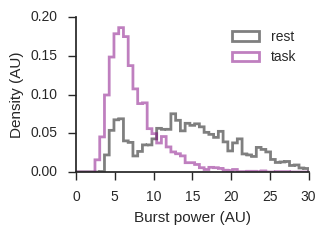

In [20]:
plt.figure(figsize=(3, 2))
plt.hist(rest_p, bins=np.linspace(0, 30, 50), 
         color='K', alpha=0.5, histtype='step', label='rest', linewidth=2, normed=1);
plt.hist(task_p, bins=np.linspace(0, 30, 50), 
         color='purple', alpha=0.5, histtype='step', label='task', linewidth=2, normed=1);
plt.xlabel("Burst power (AU)")
plt.legend()
plt.ylabel("Density (AU)")
sns.despine()
# plt.ylim(0, 35)

print(np.mean(rest_p), np.mean(task_p), np.mean(task_p)/np.mean(rest_p))
print(np.median(rest_p), np.median(task_p), np.median(task_p)/np.median(rest_p))